In [1]:
# import the required packages

# Problem1

## 1. Text Data Preprocessing

### 1.1 Load the Text Data

In [287]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
df = pd.read_csv('AA_movie_train_data.csv')

In [3]:
df.head()

,Title,Genre,Description
0,Windup (2006),action,Windup is a very original comedy. We follow B...
1,Hitman (2014),action,"Rana and Shuvo, two siblings, are very differ..."
2,Taken by Force (2010),action,When a San Francisco detective goes hunting f...
3,Bui doi Cho Lon (2013),action,"A man name Lam picks up his girlfriend, but i..."
4,Siam Yuth: The Dawn of the Kingdom (2015),action,Thap and Sin are a homeless musician brothers...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        5000 non-null   object
 1   Genre        5000 non-null   object
 2   Description  5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


In [5]:
df['Genre'].value_counts()

Genre
action         1000
comedy         1000
documentary    1000
drama          1000
thriller       1000
Name: count, dtype: int64

### 1.2 Cleanse the Text Data

In [6]:
df['Description'][0]

' Windup is a very original comedy. We follow Bernie Shaddick from his tragic childhood, through to his present day pursuit of a career as an inventor. Likened to such films as "Raising Arizona" and "The Big Lebowski", gritty cohen-esque humor saturates Bernie Shaddick\'s life, from his encounter with mace at a potential sale, to his murderous mentors posing as his Aunt Audre and Uncle Reg. Bernie is a man who, in the face of rejection and ridicule, just "doesn\'t get it", and perseveres anyways. His good nature gets on the nerves of his cruel co-workers at his commercial real estate day-job. Upholding an almost delusional enthusiasm, Bernie unknowingly sells his soul with a smile! Bernie\'s girlfriend Latrice and roommate Stuart only accentuate Bernie\'s seemingly pathetic existence. Latrice, sexy in a dirty sort of way, loves Bernie, although she would prefer to love his money, if he had any. Stuart, usually clad in underpants and obsessed with the rubix-cube, lives with Bernie becau

In [7]:
import nltk

# Choose a folder you control and exists; e.g., C:\nltk_data
download_dir = 'C:/nltk_data'

# Download resources explicitly to this directory
nltk.download('punkt', download_dir=download_dir)
nltk.download('averaged_perceptron_tagger', download_dir=download_dir)
nltk.download('wordnet', download_dir=download_dir)
nltk.download('omw-1.4', download_dir=download_dir)

# Add this directory to nltk.data.path so NLTK will find the data there
nltk.data.path.append(download_dir)

print("NLTK data path:", nltk.data.path)

NLTK data path: ['C:\\Users\\Admin/nltk_data', 'c:\\Users\\Admin\\anaconda3\\nltk_data', 'c:\\Users\\Admin\\anaconda3\\share\\nltk_data', 'c:\\Users\\Admin\\anaconda3\\lib\\nltk_data', 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data', 'C:/nltk_data']


[nltk_data] Downloading package punkt to C:/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [294]:
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# 1. Preprocessing function
def pre_process(text):
    # Lowercase
    text = text.lower()
    # Remove tags
    text = re.sub("</?.*?>", " <> ", text)
    # Remove special characters and digits
    text = re.sub("(\\d|\\W|_)+", " ", text)
    return text

# 2. Load stopwords from file + optionally add Spanish + custom
def get_stop_words(stop_file_path, include_spanish=True, extra_words=None):
    """Load stop words from file and optionally add Spanish and custom ones"""
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip().lower() for m in stopwords)

    if include_spanish:
        spanish_stopwords = set(nltk_stopwords.words('spanish'))
        stop_set.update(spanish_stopwords)

    if extra_words:
        stop_set.update(w.lower() for w in extra_words)

    return frozenset(stop_set)

# 3. Lemmatize and remove stopwords
def lemmatize_then_remove_stopwords(text, stopwords):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    # Lemmatize
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    # Remove stopwords
    filtered = [lemma for lemma in lemmas if lemma not in stopwords]
    return ' '.join(filtered)

# 4. Run it on your dataset
# Example: df['Description'] is your text column
# Replace this line with your actual DataFrame variable name
# df = pd.read_csv("your_data.csv") # if not already loaded

# Load stopwords (English + Spanish + custom)
custom_spanish = {'la', 'un', 'una', 'son', 'el', 'es', 'de'}  # You can expand this
stopwords = list(get_stop_words("stopwords.txt", include_spanish=True, extra_words=custom_spanish))

# Apply preprocessing
description_all = df['Description'].apply(pre_process)
description_all = description_all.apply(lambda x: lemmatize_then_remove_stopwords(x, stopwords))
df['description_all'] = description_all



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [75]:
description_all[0]

'windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor likened film raising arizona lebowski gritty cohen esque humor saturates bernie shaddick life encounter mace potential sale murderous mentor posing aunt audre uncle reg bernie rejection ridicule doesn perseveres anyways nature nerve cruel co worker commercial real estate day job upholding delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clad underpants obsessed rubix cube life bernie allows pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murdering meal wheel delivery boy worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murdered posed real family bernie dream invent product windup flashlight conjures laughter succeed conscience boy bernie w

In [76]:
description_all.shape

(5000,)

### 1.3 Bag-of-Word

In [277]:
#create a vocabulary of words, 
#ignore words that appear in 15% of documents, 
#eliminate stop words

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_df=0.15, stop_words=stopwords, max_features=5000)
description_counts = count_vect.fit_transform(description_all.tolist())

In [298]:
# Try different values and see vocabulary size
for max_df_val in [0.15, 0.3, 0.5, 0.7, 0.9]:
    cv = CountVectorizer(max_df=max_df_val, stop_words=stopwords)
    cv.fit(description_all)
    print(f"max_df={max_df_val}: {len(cv.vocabulary_)} unique words")

max_df=0.15: 35642 unique words
max_df=0.3: 35652 unique words
max_df=0.5: 35653 unique words
max_df=0.7: 35653 unique words
max_df=0.9: 35653 unique words


In [278]:
count_vect.stop_words

['seem',
 'things',
 'sintiendo',
 'interests',
 'said',
 'se',
 'right',
 'sean',
 'another',
 'habías',
 'habríamos',
 'been',
 'with',
 'again',
 'mrs',
 'anybody',
 'estadas',
 'places',
 'tuvieras',
 'fuese',
 'habréis',
 'alone',
 'gets',
 'there',
 'qué',
 'le',
 'vuestra',
 'became',
 'back',
 'esta',
 'opened',
 'great',
 'and',
 'tengáis',
 'however',
 'above',
 'group',
 'estemos',
 'their',
 'antes',
 'young',
 'otras',
 'algunos',
 'quienes',
 'e',
 'tenemos',
 'tendrán',
 'anywhere',
 'each',
 'this',
 'after',
 'long',
 'better',
 'grouping',
 'point',
 'es',
 'every',
 'next',
 'open',
 'its',
 'state',
 'began',
 'asking',
 'making',
 'hubiésemos',
 'keep',
 'until',
 'thoughts',
 'erais',
 'show',
 'ordered',
 'las',
 'fui',
 'goods',
 'beings',
 'estabas',
 'ti',
 'tendrían',
 'on',
 'seremos',
 'longer',
 'tuviera',
 'number',
 'the',
 'good',
 'parting',
 'give',
 'vosotras',
 'tened',
 'come',
 'put',
 'it',
 'years',
 'será',
 'c',
 'states',
 'tuviese',
 'con',


In [279]:
sum_words = description_counts.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [280]:
print('The highest frequency words:')
words_freq[0:20] 

The highest frequency words:


[('people', 962),
 ('father', 885),
 ('girl', 882),
 ('own', 842),
 ('home', 761),
 ('mother', 755),
 ('wife', 745),
 ('help', 698),
 ('meet', 690),
 ('death', 674),
 ('brother', 672),
 ('city', 659),
 ('police', 658),
 ('child', 628),
 ('daughter', 623),
 ('school', 619),
 ('town', 618),
 ('house', 609),
 ('begin', 578),
 ('set', 560)]

In [224]:
print('The lowest frequency words:')
words_freq[-20:] 

The lowest frequency words:


[('shakespeare', 11),
 ('repercussion', 11),
 ('tobacco', 11),
 ('stair', 11),
 ('remembering', 11),
 ('refers', 11),
 ('satanic', 11),
 ('pioneer', 11),
 ('caribbean', 11),
 ('stigma', 11),
 ('provocative', 11),
 ('quebec', 11),
 ('chess', 11),
 ('vanishing', 11),
 ('shaman', 11),
 ('vera', 11),
 ('unsettling', 11),
 ('scary', 11),
 ('wesley', 11),
 ('waking', 11)]

In [225]:
count_vect.get_feature_names_out()

array(['aaron', 'aarti', 'abandon', ..., 'zoe', 'zombie', 'zone'],
      dtype=object)

In [226]:
feature_names=np.array(count_vect.get_feature_names_out())
len(count_vect.get_feature_names_out())

5000

In [227]:
pd.DataFrame(description_counts.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
df_bow = pd.DataFrame(description_counts.toarray(), columns=count_vect.get_feature_names_out())
df_bow.to_csv('asg1_bow_export.csv', index=False)

### 1.4 TF-IDF

In [230]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
description_tfidf = tfidf_transformer.fit_transform(description_counts)

In [231]:
tfidf_transformer.idf_

array([7.1194979 , 7.7256337 , 6.11619579, ..., 7.32016859, 5.54710126,
       6.29851735])

In [232]:
tfidf_transformer.idf_.shape

(5000,)

In [233]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['life' 'time' 'wa' 'story' 'world' 'friend' 'film' 'family' 'day' 'love'
 'woman' 'own' 'people' 'help' 'home' 'meet' 'father' 'girl' 'wife'
 'death' 'set' 'begin' 'try' 'mother' 'city' 'soon' 'start' 'child'
 'daughter' 'police' 'night' 'brother' 'town' 'local' 'house' 'past'
 'live' 'documentary' 'decides' 'fall' 'secret' 'doe' 'school' 'look'
 'run' 'fight' 'tell' 'job' 'journey' 'dream' 'lead' 'living' 'series'
 'return' 'money' 'relationship' 'movie' 'force' 'plan' 'killed' 'real'
 'country' 'named' 'character' 'murder' 'event' 'war' 'american' 'change'
 'boy' 'left' 'sister' 'hand' 'kill' 'husband' 'student' 'dead' 'trying'
 'human' 'save' 'true' 'little' 'power' 'escape' 'former' 'attempt' 'team'
 'move' 'follows' 'head' 'evil' 'beautiful' 'action' 'drug' 'history'
 'finally' 'business' 'question' 'called' 're']


In [234]:
pd.DataFrame(description_tfidf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [235]:
# find maximum value for each of the features over dataset:
max_value = description_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['replace' 'kapoor' 'obsessive' 'pound' 'resides' 'seriously' 'continued'
 'dislike' 'dismissed' 'adding' 'actually' 'nearly' 'desperate' 'angered'
 'frame' 'odds' 'revelation' 'employed' 'smuggle' 'primarily']
Features with highest tfidf: 
['dee' 'kit' 'jake' 'arun' 'kishan' 'lily' 'perry' 'volcano' 'pierre'
 'selma' 'rider' 'di' 'jo' 'miller' 'yoga' 'wine' 'am' 'juan' 'sara'
 'local']


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [236]:
idx=0
doc = description_all[idx]
print(doc)

tf_idf_vector=description_tfidf[idx]
print(tf_idf_vector)

windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor likened film raising arizona lebowski gritty cohen esque humor saturates bernie shaddick life encounter mace potential sale murderous mentor posing aunt audre uncle reg bernie rejection ridicule doesn perseveres anyways nature nerve cruel co worker commercial real estate day job upholding delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clad underpants obsessed rubix cube life bernie allows pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murdering meal wheel delivery boy worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murdered posed real family bernie dream invent product windup flashlight conjures laughter succeed conscience boy bernie wa

In [237]:
tf_idf_vector.shape

(1, 5000)

In [238]:
temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
temp

,feature_number,tf_idf
0,58,0.064273
1,147,0.081266
2,246,0.093302
3,329,0.339619
4,406,0.083423
...,...,...
94,4888,0.193146
95,4895,0.087171
96,4941,0.064502
97,4950,0.128774


In [239]:
temp.sort_values('tf_idf', ascending = False, inplace = True)
temp

,feature_number,tf_idf
3,329,0.339619
90,4663,0.283604
71,3550,0.203758
85,4277,0.198590
94,4888,0.193146
...,...,...
19,1120,0.046752
41,1897,0.043312
35,1646,0.037010
37,1711,0.036427


In [240]:
#use only topn items from vector
topn = 20   
topn_items = temp[:topn]

tf_idf = []
word = []

for index, row in topn_items.iterrows():
    fname = feature_names[int(row['feature_number'])]
    word.append(fname)
    tf_idf.append(round(row['tf_idf'], 3))    

In [241]:
print(doc, '\n')

result = dict(zip(word, tf_idf))
print(result)

windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor likened film raising arizona lebowski gritty cohen esque humor saturates bernie shaddick life encounter mace potential sale murderous mentor posing aunt audre uncle reg bernie rejection ridicule doesn perseveres anyways nature nerve cruel co worker commercial real estate day job upholding delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clad underpants obsessed rubix cube life bernie allows pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murdering meal wheel delivery boy worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murdered posed real family bernie dream invent product windup flashlight conjures laughter succeed conscience boy bernie wa

In [242]:
topn = 20
results =[]

In [243]:
for idx, doc in description_all.items():
    #generate tf-idf for the given document
    tf_idf_vector=description_tfidf[idx]
    
    temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
    temp.sort_values('tf_idf', ascending = False, inplace = True)
    
    #use only topn items from vector
     
    topn_items = temp[:topn]

    tf_idf = []
    word = []

    for index, row in topn_items.iterrows():
        #print(int(row['feature_number']))
        fname = feature_names[int(row['feature_number'])]
        word.append(fname)
        tf_idf.append(round(row['tf_idf'], 3))

    result = dict(zip(word, tf_idf))
    
    results.append(result)


In [244]:
len(results)

5000

In [245]:
df['cleansed_review'] = description_all
df['keywords'] = results
df.head()

,Title,Genre,Description,cleansed_review,keywords
0,Windup (2006),action,Windup is a very original comedy. We follow B...,windup original comedy follow bernie shaddick ...,"{'aunt': 0.34, 'uncle': 0.284, 'real': 0.204, ..."
1,Hitman (2014),action,"Rana and Shuvo, two siblings, are very differ...",rana shuvo sibling father wa police constable ...,"{'brother': 0.297, 'crime': 0.23, 'bravery': 0..."
2,Taken by Force (2010),action,When a San Francisco detective goes hunting f...,san francisco detective hunting cruel asian cr...,"{'nelson': 0.533, 'violent': 0.218, 'detective..."
3,Bui doi Cho Lon (2013),action,"A man name Lam picks up his girlfriend, but i...",name lam pick girlfriend revealed girlfriend a...,"{'gangster': 0.568, 'martial': 0.39, 'artist':..."
4,Siam Yuth: The Dawn of the Kingdom (2015),action,Thap and Sin are a homeless musician brothers...,thap homeless musician brother village wa raid...,"{'ram': 0.765, 'prince': 0.338, 'kingdom': 0.2..."


In [246]:
df.to_csv('asg1_tfidf_export.csv')

### 2.2 Association Rules Mining on keywords

In [247]:
transactions = [list(d.keys()) for d in results]
print(transactions)

[['aunt', 'uncle', 'real', 'stuart', 'welfare', 'cuban', 'mentor', 'product', 'commercial', 'estate', 'co', 'worker', 'deal', 'life', 'boy', 'grandma', 'money', 'dream', 'smile', 'rejection'], ['brother', 'crime', 'bravery', 'assumes', 'extent', 'police', 'arises', 'promoted', 'tall', 'tackle', 'assist', 'villain', 'sibling', 'brave', 'onto', 'elder', 'duty', 'courage', 'brutally', 'lack'], ['nelson', 'violent', 'detective', 'asian', 'francisco', 'device', 'san', 'capture', 'terrorist', 'center', 'partner', 'gang', 'art', 'triad', 'operating', 'dragon', 'furious', 'tactic', 'edward', 'lieutenant'], ['gangster', 'martial', 'artist', 'girlfriend', 'brother', 'kill', 'furious', 'trap', 'fight', 'revealed', 'attacking', 'enraged', 'lay', 'protection', 'guilty', 'double', 'learning', 'pick', 'beat', 'hire'], ['ram', 'prince', 'kingdom', 'village', 'plan', 'stir', 'residence', 'frame', 'meet', 'villager', 'homeless', 'musician', 'destroy', 'determined', 'justice', 'enemy', 'lover', 'mission'

In [248]:
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

te = TransactionEncoder()
data_encoded = te.fit_transform(transactions)
data_encoded = pd.DataFrame(data_encoded, columns=te.columns_)

data_encoded.shape

(5000, 5000)

In [249]:
# Step 1: Count how often each keyword appears across all transactions
keyword_freq = data_encoded.sum(axis=0)

# Step 2: Select the top 200 most frequent keywords
top_200_keywords = keyword_freq.sort_values(ascending=False).head(200).index

# Step 3: Filter the data to just those 200 keywords
data_encoded_filtered = data_encoded[top_200_keywords]


In [250]:
# Create a DataFrame of keywords and their frequencies
top_keywords_df = keyword_freq[top_200_keywords].reset_index()
top_keywords_df.columns = ['Keyword', 'Frequency']

# Export to CSV
top_keywords_df.to_csv('top_200_keywords.csv', index=False)


In [251]:
data_encoded_filtered.shape

(5000, 200)

In [252]:
data_encoded_filtered

,film,life,wa,family,woman,friend,girl,father,love,brother,...,building,travel,five,culture,college,india,bar,tv,neighborhood,camera
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<Axes: title={'center': 'Keyword Frequency Distribution'}, ylabel='Frequency'>

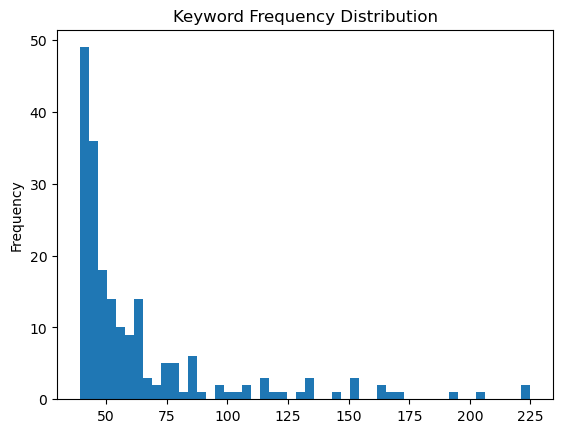

In [253]:
keyword_counts = data_encoded_filtered.sum().sort_values(ascending=False)
keyword_counts.plot(kind='hist', bins=50, title="Keyword Frequency Distribution")

In [254]:
for support in [0.05, 0.01, 0.005, 0.003, 0.002, 0.001]:
    itemsets = apriori(data_encoded_filtered, min_support=support, use_colnames=True)
    print(f"Support: {support}, Itemsets: {itemsets.shape[0]}")

Support: 0.05, Itemsets: 0
Support: 0.01, Itemsets: 101
Support: 0.005, Itemsets: 200
Support: 0.003, Itemsets: 215
Support: 0.002, Itemsets: 276
Support: 0.001, Itemsets: 787


In [255]:
from mlxtend.frequent_patterns import apriori

#First, let us return the items and itemsets with at least 1% support:
frequent_itemsets=apriori(data_encoded_filtered, min_support = 0.002, use_colnames = True)

In [256]:
# Export to CSV
frequent_itemsets.to_csv('frequent_itemsets.csv', index=False)


In [257]:
frequent_itemsets

,support,itemsets
0,0.0450,(film)
1,0.0446,(life)
2,0.0408,(wa)
3,0.0386,(family)
4,0.0340,(woman)
...,...,...
271,0.0026,"(artist, art)"
272,0.0040,"(martial, art)"
273,0.0022,"(gang, street)"
274,0.0028,"(gang, leader)"


In [258]:
frequent_itemsets[['support']].describe()

,support
count,276.000000
mean,0.009971
std,0.007624
min,0.002000
25%,0.003550
50%,0.008700
75%,0.011800
max,0.045000


In [259]:
rules_c = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)
rules_c


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(wa),(film),0.0408,0.0450,0.0022,0.053922,1.198257,1.0,0.000364,1.009430,0.172492,0.026316,0.009342,0.051405
1,(world),(film),0.0302,0.0450,0.0022,0.072848,1.618837,1.0,0.000841,1.030036,0.394177,0.030137,0.029160,0.060868
2,(people),(film),0.0246,0.0450,0.0022,0.089431,1.987353,1.0,0.001093,1.048795,0.509348,0.032641,0.046524,0.069160
3,(city),(film),0.0228,0.0450,0.0020,0.087719,1.949318,1.0,0.000974,1.046827,0.498363,0.030395,0.044732,0.066082
4,(film),(movie),0.0450,0.0170,0.0030,0.066667,3.921569,1.0,0.002235,1.053214,0.780105,0.050847,0.050526,0.121569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,(street),(gang),0.0116,0.0150,0.0022,0.189655,12.643678,1.0,0.002026,1.215532,0.931717,0.090164,0.177315,0.168161
136,(gang),(leader),0.0150,0.0092,0.0028,0.186667,20.289855,1.0,0.002662,1.218197,0.965192,0.130841,0.179115,0.245507
137,(leader),(gang),0.0092,0.0150,0.0028,0.304348,20.289855,1.0,0.002662,1.415938,0.959542,0.130841,0.293754,0.245507
138,(blood),(vampire),0.0102,0.0082,0.0026,0.254902,31.085605,1.0,0.002516,1.331100,0.977804,0.164557,0.248742,0.285988


In [260]:
rules_c.sort_values('confidence', ascending = False, inplace = True)
rules_c.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
132,(martial),(art),0.0080,0.0154,0.0040,0.500000,32.467532,1.0,0.003877,1.969200,0.977016,0.206186,0.492180,0.379870
107,(officer),(police),0.0092,0.0268,0.0044,0.478261,17.845555,1.0,0.004153,1.865300,0.952729,0.139241,0.463893,0.321220
104,(inspector),(police),0.0096,0.0268,0.0044,0.458333,17.101990,1.0,0.004143,1.796677,0.950654,0.137500,0.443417,0.311256
8,(director),(film),0.0088,0.0450,0.0032,0.363636,8.080808,1.0,0.002804,1.500714,0.884029,0.063241,0.333651,0.217374
139,(vampire),(blood),0.0082,0.0102,0.0026,0.317073,31.085605,1.0,0.002516,1.449350,0.975833,0.164557,0.310036,0.285988
102,(killed),(police),0.0104,0.0268,0.0032,0.307692,11.481056,1.0,0.002921,1.405733,0.922494,0.094118,0.288628,0.213548
137,(leader),(gang),0.0092,0.0150,0.0028,0.304348,20.289855,1.0,0.002662,1.415938,0.959542,0.130841,0.293754,0.245507
121,(teacher),(school),0.0090,0.0258,0.0026,0.288889,11.197244,1.0,0.002368,1.369969,0.918963,0.080745,0.270056,0.194832
128,(college),(student),0.0078,0.0172,0.0022,0.282051,16.398330,1.0,0.002066,1.368900,0.946400,0.096491,0.269486,0.204979
110,(singh),(police),0.0086,0.0268,0.0024,0.279070,10.413051,1.0,0.002170,1.349923,0.911808,0.072727,0.259217,0.184311


<Axes: >

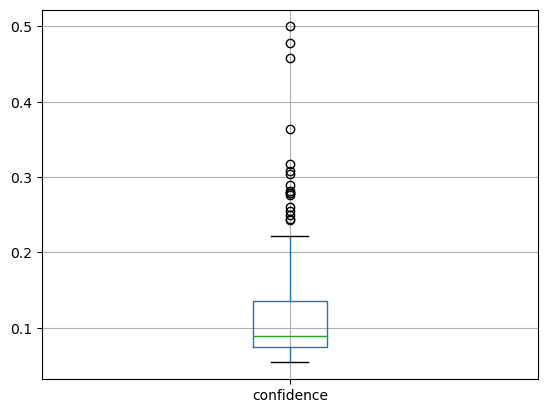

In [261]:
rules_c[['confidence']].boxplot()

In [262]:
from mlxtend.frequent_patterns import association_rules

rules_l = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_l

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(wa),(film),0.0408,0.0450,0.0022,0.053922,1.198257,1.0,0.000364,1.009430,0.172492,0.026316,0.009342,0.051405
1,(film),(wa),0.0450,0.0408,0.0022,0.048889,1.198257,1.0,0.000364,1.008505,0.173251,0.026316,0.008433,0.051405
2,(film),(world),0.0450,0.0302,0.0022,0.048889,1.618837,1.0,0.000841,1.019650,0.400286,0.030137,0.019271,0.060868
3,(world),(film),0.0302,0.0450,0.0022,0.072848,1.618837,1.0,0.000841,1.030036,0.394177,0.030137,0.029160,0.060868
4,(film),(people),0.0450,0.0246,0.0022,0.048889,1.987353,1.0,0.001093,1.025537,0.520228,0.032641,0.024901,0.069160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,(street),(gang),0.0116,0.0150,0.0022,0.189655,12.643678,1.0,0.002026,1.215532,0.931717,0.090164,0.177315,0.168161
148,(gang),(leader),0.0150,0.0092,0.0028,0.186667,20.289855,1.0,0.002662,1.218197,0.965192,0.130841,0.179115,0.245507
149,(leader),(gang),0.0092,0.0150,0.0028,0.304348,20.289855,1.0,0.002662,1.415938,0.959542,0.130841,0.293754,0.245507
150,(blood),(vampire),0.0102,0.0082,0.0026,0.254902,31.085605,1.0,0.002516,1.331100,0.977804,0.164557,0.248742,0.285988


In [263]:
rules_l.sort_values('lift', ascending = False, inplace = True)
rules_l.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
145,(art),(martial),0.0154,0.0080,0.0040,0.259740,32.467532,1.0,0.003877,1.340070,0.984359,0.206186,0.253770,0.379870
144,(martial),(art),0.0080,0.0154,0.0040,0.500000,32.467532,1.0,0.003877,1.969200,0.977016,0.206186,0.492180,0.379870
150,(blood),(vampire),0.0102,0.0082,0.0026,0.254902,31.085605,1.0,0.002516,1.331100,0.977804,0.164557,0.248742,0.285988
151,(vampire),(blood),0.0082,0.0102,0.0026,0.317073,31.085605,1.0,0.002516,1.449350,0.975833,0.164557,0.310036,0.285988
149,(leader),(gang),0.0092,0.0150,0.0028,0.304348,20.289855,1.0,0.002662,1.415938,0.959542,0.130841,0.293754,0.245507
148,(gang),(leader),0.0150,0.0092,0.0028,0.186667,20.289855,1.0,0.002662,1.218197,0.965192,0.130841,0.179115,0.245507
118,(police),(officer),0.0268,0.0092,0.0044,0.164179,17.845555,1.0,0.004153,1.185421,0.969959,0.139241,0.156418,0.321220
119,(officer),(police),0.0092,0.0268,0.0044,0.478261,17.845555,1.0,0.004153,1.865300,0.952729,0.139241,0.463893,0.321220
116,(inspector),(police),0.0096,0.0268,0.0044,0.458333,17.101990,1.0,0.004143,1.796677,0.950654,0.137500,0.443417,0.311256
117,(police),(inspector),0.0268,0.0096,0.0044,0.164179,17.101990,1.0,0.004143,1.184943,0.967455,0.137500,0.156077,0.311256


<Axes: >

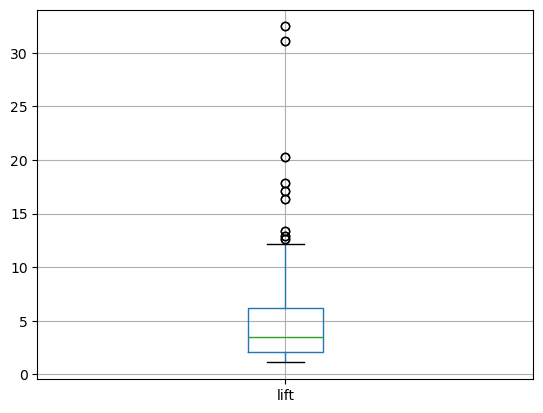

In [264]:
rules_l[['lift']].boxplot()

In [265]:
# Option A
rules_c[ (rules_c['lift'] >= 1.5) &
       (rules_c['confidence'] >= 0.2) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
132,(martial),(art),0.0080,0.0154,0.0040,0.500000,32.467532,1.0,0.003877,1.969200,0.977016,0.206186,0.492180,0.379870
107,(officer),(police),0.0092,0.0268,0.0044,0.478261,17.845555,1.0,0.004153,1.865300,0.952729,0.139241,0.463893,0.321220
104,(inspector),(police),0.0096,0.0268,0.0044,0.458333,17.101990,1.0,0.004143,1.796677,0.950654,0.137500,0.443417,0.311256
8,(director),(film),0.0088,0.0450,0.0032,0.363636,8.080808,1.0,0.002804,1.500714,0.884029,0.063241,0.333651,0.217374
139,(vampire),(blood),0.0082,0.0102,0.0026,0.317073,31.085605,1.0,0.002516,1.449350,0.975833,0.164557,0.310036,0.285988
102,(killed),(police),0.0104,0.0268,0.0032,0.307692,11.481056,1.0,0.002921,1.405733,0.922494,0.094118,0.288628,0.213548
137,(leader),(gang),0.0092,0.0150,0.0028,0.304348,20.289855,1.0,0.002662,1.415938,0.959542,0.130841,0.293754,0.245507
121,(teacher),(school),0.0090,0.0258,0.0026,0.288889,11.197244,1.0,0.002368,1.369969,0.918963,0.080745,0.270056,0.194832
128,(college),(student),0.0078,0.0172,0.0022,0.282051,16.398330,1.0,0.002066,1.368900,0.946400,0.096491,0.269486,0.204979
110,(singh),(police),0.0086,0.0268,0.0024,0.279070,10.413051,1.0,0.002170,1.349923,0.911808,0.072727,0.259217,0.184311


In [266]:
# Option B
rules_l[ (rules_l['lift'] >= 1.5) &
       (rules_l['confidence'] >= 0.2) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
145,(art),(martial),0.0154,0.0080,0.0040,0.259740,32.467532,1.0,0.003877,1.340070,0.984359,0.206186,0.253770,0.379870
144,(martial),(art),0.0080,0.0154,0.0040,0.500000,32.467532,1.0,0.003877,1.969200,0.977016,0.206186,0.492180,0.379870
150,(blood),(vampire),0.0102,0.0082,0.0026,0.254902,31.085605,1.0,0.002516,1.331100,0.977804,0.164557,0.248742,0.285988
151,(vampire),(blood),0.0082,0.0102,0.0026,0.317073,31.085605,1.0,0.002516,1.449350,0.975833,0.164557,0.310036,0.285988
149,(leader),(gang),0.0092,0.0150,0.0028,0.304348,20.289855,1.0,0.002662,1.415938,0.959542,0.130841,0.293754,0.245507
119,(officer),(police),0.0092,0.0268,0.0044,0.478261,17.845555,1.0,0.004153,1.865300,0.952729,0.139241,0.463893,0.321220
116,(inspector),(police),0.0096,0.0268,0.0044,0.458333,17.101990,1.0,0.004143,1.796677,0.950654,0.137500,0.443417,0.311256
140,(college),(student),0.0078,0.0172,0.0022,0.282051,16.398330,1.0,0.002066,1.368900,0.946400,0.096491,0.269486,0.204979
142,(artist),(art),0.0126,0.0154,0.0026,0.206349,13.399299,1.0,0.002406,1.240596,0.937178,0.102362,0.193936,0.187590
139,(teacher),(student),0.0090,0.0172,0.0020,0.222222,12.919897,1.0,0.001845,1.263600,0.930979,0.082645,0.208610,0.169251


# Problem2

## 3. Classification Modeling

### 3.1 Sample the data

In [295]:
#Creating the X and y variables
X = df.drop('description_all', axis =1).values
y = df['Genre'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1)

In [ ]:
param_grid = {"max_depth": [3,5, 7, 10],
              "n_estimators":[3,5,10,25,50,150]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

gs = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=4)
gs.fit(X_train, y_train)

c:\Users\Admin\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Admin\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
c:\Users\Admin\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Admin\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

### 3.2 Build the Model(s)

### 3.3 Evaluate and Improve the Model(s)